# SI140@fall2021 project

## metadata

- abstract: performance evalutaion of classical MAB algorithms
- DUE date: 2022/01/16 11:59am
- author: spinach/hehelego (彭程 pengcheng2 2020533068)

## environment

- OS: arch linux
- kernel: 5.15.7-arch1-1
- Arch: x86-64 (amd64)
- python: version 3.9.9
- ipython: version 7.30.1
- ipython-kernel: 6.6.0
- numpy: version 1.21.3
- matplotlib: version 3.5.0

## table of contents

- MAB setup
- implementation of the three appointed classical bandit learning algorithms
- implementation of several more algorithms
- simulation
- performance analysis

The above sections can be found in this jupyter notebook,
while the discussion section can be found in `report.pdf`.

## code style

- multiple statement in one line is now allowed
- identifier for variable      `snake_case`
- identifier for constant      `SANKE_CASE`
- identifier for function      `snake_case`
- identifier for class         `CamelCase`
- identifier for method        `snake_case`
- identifier for property      `snake_case`
- identifier for class method  `snake_case`
- identifier for static method `snake_case`

### Sampling from $\mathrm{Beta}(a,b)$ with integer paramters

Suppose that $X\sim \mathrm{Gamma}(a,\lambda), Y\sim \mathrm{Gamma}(b,\lambda)$ be independent,
let $T=X+Y,W=\frac{X}{X+Y}$.  
By _bank post-office_ story, we have $T\sim\mathrm{Gamma}(a+b,\lambda), W\sim \mathrm{Beta}(a,b)$  
After some testing, we found that bigger $\lambda$ is better.

Alternatively, we can use the $a$-th ordered statistics of $a+b-1$ i.i.d. $\mathrm{Unif}(0,1)$ r.v.s.  


### Sampling from $\mathrm{Gamma}(n,\lambda)$ distribution

Let $X_1,X_2\ldots X_n$ be $n$ i.i.d. $\mathrm{Expo}(\lambda)$ r.v.s,
then their sum $S=\sum_{i=1}^n X_i$ has a $\mathrm{Gamma}(n,\lambda)$ distribution.

### Generating $\mathrm{Expo}(\lambda)$ from $\mathrm{Unif}(0,1)$

The CDF of $\mathrm{Expo}(\lambda)$ is $F(x)=1-e^{-\lambda x}, F^{-1}(x) = -\frac{\ln (1-x)}{\lambda}$.  
Let $U\sim\mathrm{Unif}(0,1)$ then $X=F^{-1}(U)$ has a $\mathrm{Expo}(\lambda)$ distribution.

### Declaration

However, the above methods are of poor performance, which in turn becomes the bottle neck of our program.  
I found a classic paper _[Computer methods for sampling from gamma, beta, poisson and bionomial distributions
](https://link.springer.com/article/10.1007/BF02293108)_ which covers efficient algorithms for random samples generation.  

***TODO:*** implement the beta-distribution generating method from the paper  
Currently, `numpy.random.beta, nupy.random.gamma` is employed to draw random samples.

## section: MAB setup

In [1]:
import numpy as np
import numpy.random as npr
import numpy.typing as npt
import abc
import typing

# the (pesudo) random number generator
rng = npr.Generator(npr.MT19937(19260817))


def natural_number_stream(start: int = 0) -> typing.Iterator[int]:
    r'''
    generate a natural number stream [start, start+1, start+2, ...]
    '''
    while True:
        yield start
        start += 1


def argmax(xs: typing.Iterable) -> int:
    r'''
    index of the maximum element
    '''
    return max(zip(natural_number_stream(), xs), key=lambda kv: kv[1])[0]


def argmin(xs: typing.Iterable) -> int:
    r'''
    index of the minimum element
    '''
    return max(zip(natural_number_stream(), xs), key=lambda kv: -kv[1])[0]


class Sampling:
    r'''
    sampling named distribution

    methods for single sample generation:
    - uniform(a,b):        $\mathrm{Unif}(a,b)$
    - bernoulli(p):        $\mathrm{Bern}(p)$
    - exponential(rate):   $\mathrm{Expo}(\lambda)$, where rate is the $\lambda$ parameter.
    - gamma(n,rate):       $\mathrm{Gamma}(a,\lambda)$, where $a$ is $n$ and $\lambda$ is rate.

    methods for multiple i.i.d. samples generation:
    - uniform_array
    - bernoulli_array
    - exponential_array
    '''

    @staticmethod
    def uniform(a: float = 0, b: float = 1) -> float:
        return a+(b-a)*rng.random()

    @staticmethod
    def uniform_array(size: int, a: float = 0, b: float = 1) -> npt.NDArray[np.float_]:
        return a+(b-a)*rng.random(size)

    @staticmethod
    def bernoulli(prob: float) -> bool:
        return Sampling.uniform() < prob

    @staticmethod
    def bernoulli_array(size: int, prob: float) -> npt.NDArray[np.bool_]:
        return Sampling.uniform_array(size) < prob

    @staticmethod
    def exponential(rate: float = 1) -> float:
        return -np.log(1-Sampling.uniform())/rate

    @staticmethod
    def exponential_array(size: int, rate: float = 1) -> npt.NDArray[np.float_]:
        return -np.log(1-Sampling.uniform_array(size))/rate

    @staticmethod
    def gamma(n: int, rate: float = 1) -> float:
        # return Sampling.exponential_array(n, rate).sum()
        return rng.gamma(n, rate)

    @staticmethod
    def beta(a: int, b: int, _rate: float = 1000) -> float:
        # x, y = Sampling.gamma(a, _rate), Sampling.gamma(b, _rate)
        # return x/(x+y)
        return rng.beta(a, b)


class MAB:
    r'''
    the multi-armed bandit
    '''

    def __init__(self, theta: list[float]):
        self.theta = theta[:]
        self.arms = len(theta)

    def pull(self, i: int) -> int:
        return int(Sampling.bernoulli(self.theta[i]))

    def oracle_value(self, n: int) -> float:
        return n*max(self.theta)


class Strategy(abc.ABC):
    r'''
    the abstract base class for bandit algorithms
    '''

    def __init__(self, mab: MAB, n: int):
        self.mab = mab
        self.n = n

    @abc.abstractmethod
    def run(self) -> int:
        '''
        perform one simulation: n pulls
        '''
        ...

    @property
    @abc.abstractmethod
    def profile(self) -> str:
        '''
        return the strategy/algorithm name and value of parameters
        '''
        ...

## section: implementation of classical bandit learning algorithms

In [2]:
class EpsilonGreedy(Strategy):
    def __init__(self, mab: MAB, n: int, eps: float):
        super().__init__(mab, n)
        self._profile = f'EpsilonGreedy(epsilon={eps})'
        self.eps = eps
        self.count = [int(0) for _ in range(mab.arms)]
        self.theta_hat = [float(0) for _ in range(mab.arms)]

    def run(self) -> int:
        earn = 0
        for _ in range(self.n):
            arm = argmax(self.count)
            if Sampling.bernoulli(self.eps):
                arm = rng.integers(self.mab.arms)
            reward = self.mab.pull(arm)
            earn += reward

            self.count[arm] += 1
            self.theta_hat[arm] += (reward-self.theta_hat[arm])/self.count[arm]

        return earn

    @property
    def profile(self) -> str:
        return self._profile


class UpperConfidenceBound(Strategy):
    def __init__(self, mab: MAB, n: int, c: float):
        super().__init__(mab, n)
        self._profile = f'UpperConfidenceBound(c={c})'
        self.c = c
        self.count = [int(0) for _ in range(mab.arms)]
        self.theta_hat = [float(0) for _ in range(mab.arms)]

    def run(self) -> int:
        from math import log, sqrt
        earn = 0
        for t in range(self.mab.arms):
            reward = self.mab.pull(t)
            earn += reward

            self.count[t] = 1
            self.theta_hat[t] = reward

        for t in range(self.mab.arms, self.n):
            arm = argmax(self.theta_hat[i] + self.c*sqrt(2*log(t+1)/self.count[i])
                         for i in range(self.mab.arms))
            reward = self.mab.pull(arm)
            earn += reward

            self.count[arm] += 1
            self.theta_hat[arm] += (reward-self.theta_hat[arm])/self.count[arm]

        return earn

    @property
    def profile(self) -> str:
        return self._profile


class ThompsonSampling(Strategy):
    def __init__(self, mab: MAB, n: int, prior: list[tuple[int, int]]):
        super().__init__(mab, n)
        self.beta_parameters = [list(i) for i in prior]
        self._profile = f'ThompsonSampling({prior})'

    def run(self) -> int:
        earn = 0
        for _ in range(self.n):
            theta_hat = [Sampling.beta(a, b)
                         for (a, b) in self.beta_parameters]
            arm = argmax(theta_hat)
            reward = self.mab.pull(arm)
            earn += reward

            self.beta_parameters[arm][0] += reward
            self.beta_parameters[arm][1] += 1-reward

        return earn

    @property
    def profile(self) -> str:
        return self._profile

## section: several more algorithms

In [3]:
class EpsilonDecreaseGreedy(Strategy):
    def __init__(self, mab: MAB, n: int, eps: float, shrink_factor: float):
        super().__init__(mab, n)
        self._profile = f'EpsilonDecreaseGreedy(epsilon={eps}, shrink_factor={shrink_factor})'
        self.eps = eps
        self.shrink_factor = shrink_factor
        self.count = [int(0) for _ in range(mab.arms)]
        self.theta_hat = [float(0) for _ in range(mab.arms)]

    def run(self) -> int:
        earn = 0
        for _ in range(self.n):
            arm = argmax(self.count)
            if Sampling.bernoulli(self.eps):
                arm = rng.integers(self.mab.arms)
            reward = self.mab.pull(arm)
            earn += reward

            self.count[arm] += 1
            self.theta_hat[arm] += (reward-self.theta_hat[arm])/self.count[arm]

            self.eps *= self.shrink_factor

        return earn

    @property
    def profile(self) -> str:
        return self._profile

## section: simulation

In [7]:
RUNS = 200
N = 6000
mab = MAB([0.8, 0.6, 0.5])


def once() -> dict[str, int]:
    eps_gre: list[Strategy] = [
        EpsilonGreedy(mab, N, 0.2),
        EpsilonGreedy(mab, N, 0.4),
        EpsilonGreedy(mab, N, 0.6),
        EpsilonGreedy(mab, N, 0.8),
    ]
    eps_dec_gre: list[Strategy] = [
        EpsilonDecreaseGreedy(mab, N, 1, 0.95),
        EpsilonDecreaseGreedy(mab, N, 0.5, 0.95),
        EpsilonDecreaseGreedy(mab, N, 0.2, 0.99),
    ]
    ucb: list[Strategy] = [
        UpperConfidenceBound(mab, N, 0.3),
        UpperConfidenceBound(mab, N, 0.5),
        UpperConfidenceBound(mab, N, 0.8),
        UpperConfidenceBound(mab, N, 1),
        UpperConfidenceBound(mab, N, 2),
        UpperConfidenceBound(mab, N, 6),
        UpperConfidenceBound(mab, N, 9),
    ]
    ts: list[Strategy] = [
        ThompsonSampling(mab, N, [(1, 1), (1, 1), (1, 1)]),
        ThompsonSampling(mab, N, [(601, 401), (401, 601), (2, 3)]),
        ThompsonSampling(mab, N, [(8, 2), (6, 4), (5, 5)]),
        ThompsonSampling(mab, N, [(80, 20), (6, 4), (5, 5)]),
    ]
    all_in_one = eps_gre + eps_dec_gre + ucb + ts

    return {
        s.profile: s.run()
        for s in all_in_one
    }

def average(xs):
    return sum(xs) / len(xs)


tmp=once()
rec: dict[str,list[int]] = {k:[v] for (k,v) in tmp.items()}
for _ in range(RUNS):
    out = once()
    for (k,v) in tmp.items():
        rec[k].append(v)

In [8]:
print(f'orcale {mab.oracle_value(N)}')
for (k,v) in rec.items():
    print(f'{k}\t{average(v)}')

orcale 4800.0
EpsilonGreedy(epsilon=0.2)	4603.0
EpsilonGreedy(epsilon=0.4)	4388.0
EpsilonGreedy(epsilon=0.6)	3692.0
EpsilonGreedy(epsilon=0.8)	3946.0
EpsilonDecreaseGreedy(epsilon=1, shrink_factor=0.95)	4769.0
EpsilonDecreaseGreedy(epsilon=0.5, shrink_factor=0.95)	4792.0
EpsilonDecreaseGreedy(epsilon=0.2, shrink_factor=0.99)	4822.0
UpperConfidenceBound(c=0.3)	4738.0
UpperConfidenceBound(c=0.5)	4751.0
UpperConfidenceBound(c=0.8)	4773.0
UpperConfidenceBound(c=1)	4738.0
UpperConfidenceBound(c=2)	4553.0
UpperConfidenceBound(c=6)	4093.0
UpperConfidenceBound(c=9)	4027.0
ThompsonSampling([(1, 1), (1, 1), (1, 1)])	4796.0
ThompsonSampling([(601, 401), (401, 601), (2, 3)])	4773.0
ThompsonSampling([(8, 2), (6, 4), (5, 5)])	4773.0
ThompsonSampling([(80, 20), (6, 4), (5, 5)])	4790.0


## section: testing

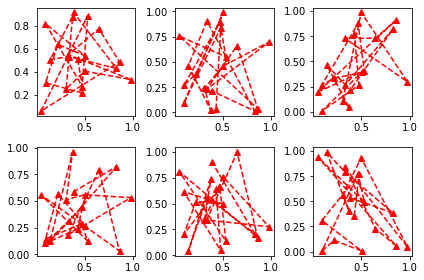

In [6]:
from matplotlib import pyplot as plt

x = rng.random(20)
fig, ax = plt.subplots(2, 3)
for i in range(2):
    for j in range(3):
        y = rng.random(20)
        ax[i][j].plot(x, y, 'r^--')
        
fig.tight_layout()
plt.show()